In [3]:
import attacks
import models
from models import process_model_type
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, iter, attack_type, device):
    
    whitebox = whitebox.to(device)
    whitebox.eval()
    
    ATK_EPS = eps
    ATK_ITERS = iter
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)
    
    whitebox_correct = 0.
    running_total = 0.
    for batch_idx, (data, labels) in enumerate(test_loader):
        # print(data.shape)
        # print(labels.shape)
        data = data.to(device)
        # data = trans(data)
        # print(torch.mean(data))
        labels = labels.to(device)
        if attack_type == "random_noise_attack":
            adv_data = attacks.random_noise_attack(model=net, device=device, dat=data, eps=ATK_EPS)
        elif attack_type == "PGD":
            adv_data = attacks.PGD_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, rand_start=True)
        elif attack_type == "FGM_L2":
            adv_data = attacks.FGM_L2_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        elif attack_type == "rFGSM":
            adv_data = attacks.rFGSM_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        else:
            adv_data = attacks.FGSM_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        # print(torch.max(torch.abs(adv_data-data)))
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-3) )

        # invTrans(adv_data)

        with torch.no_grad():
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
    whitebox_acc = whitebox_correct/running_total
    
    return whitebox_acc

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print("device:", device)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [1/0.2023, 1/0.1994, 1/0.2010]),
                                transforms.Normalize(mean = [-0.4914, -0.4822, -0.4465],
                                                     std = [ 1., 1., 1. ]),
                               ])
trans = transforms.Compose([
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)

device: cuda
Files already downloaded and verified


acc: 0.6527
done: 0.0
acc: 0.3746
done: 0.030596666666666668
acc: 0.2667
done: 0.061193333333333336
acc: 0.1926
done: 0.09179000000000001
acc: 0.1453
done: 0.12238666666666667
acc: 0.1149
done: 0.15298333333333333
acc: 0.0946
done: 0.18358000000000002
acc: 0.0787
done: 0.21417666666666668
acc: 0.0686
done: 0.24477333333333334
acc: 0.0631
done: 0.27537
[0.6527, 0.3746, 0.2667, 0.1926, 0.1453, 0.1149, 0.0946, 0.0787, 0.0686, 0.0631]


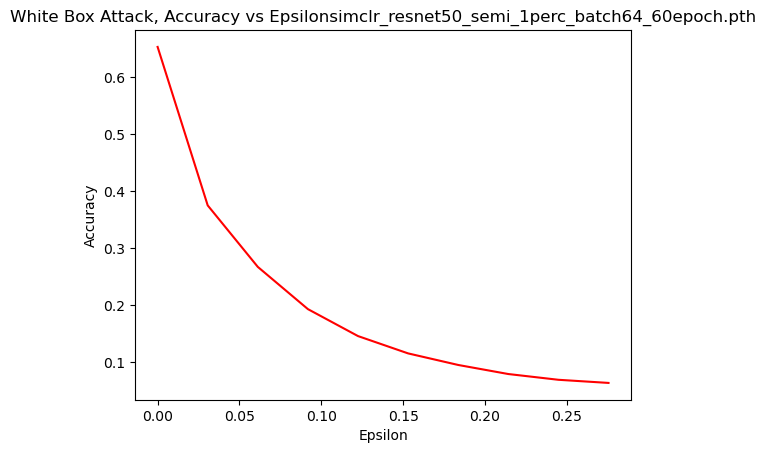

In [8]:
PATH = "simclr_resnet50_semi_1perc_batch64_60epoch.pth"
load_model="test_linear_eval"
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

net = process_model_type("simclr_resnet50", load_model="test_linear_eval")
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("simclr_resnet50", load_model="test_linear_eval")
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)
for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "PGD", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
    # plt.ylim(0, 1)
plt.show()

acc: 0.8217
done: 0.0
acc: 0.4895
done: 0.030596666666666668
acc: 0.3561
done: 0.061193333333333336
acc: 0.2675
done: 0.09179000000000001
acc: 0.2055
done: 0.12238666666666667
acc: 0.1686
done: 0.15298333333333333
acc: 0.1411
done: 0.18358000000000002
acc: 0.1253
done: 0.21417666666666668
acc: 0.1095
done: 0.24477333333333334
acc: 0.0963
done: 0.27537
[0.8217, 0.4895, 0.3561, 0.2675, 0.2055, 0.1686, 0.1411, 0.1253, 0.1095, 0.0963]


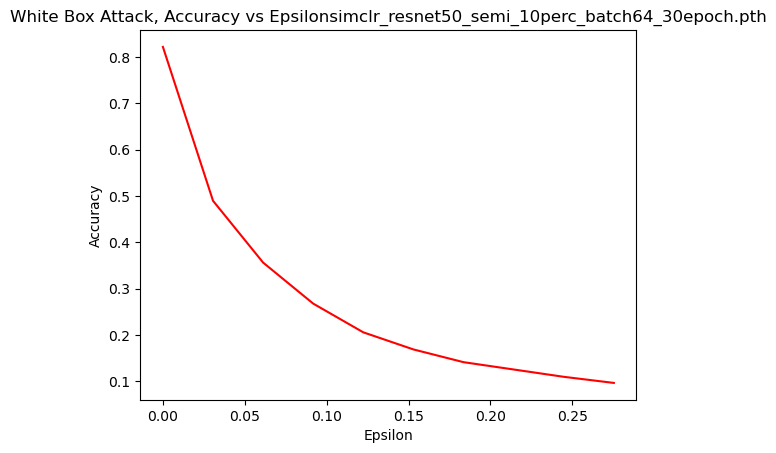

In [9]:
PATH = "simclr_resnet50_semi_10perc_batch64_30epoch.pth"
load_model="test_linear_eval"
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

net = process_model_type("simclr_resnet50", load_model="test_linear_eval")
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("simclr_resnet50", load_model="test_linear_eval")
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)

for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "PGD", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

acc: 0.8702
done: 0.0
acc: 0.4511
done: 0.030596666666666668
acc: 0.3015
done: 0.061193333333333336
acc: 0.2154
done: 0.09179000000000001
acc: 0.166
done: 0.12238666666666667
acc: 0.13
done: 0.15298333333333333
acc: 0.1043
done: 0.18358000000000002
acc: 0.0924
done: 0.21417666666666668
acc: 0.0797
done: 0.24477333333333334
acc: 0.0707
done: 0.27537
[0.8702, 0.4511, 0.3015, 0.2154, 0.166, 0.13, 0.1043, 0.0924, 0.0797, 0.0707]


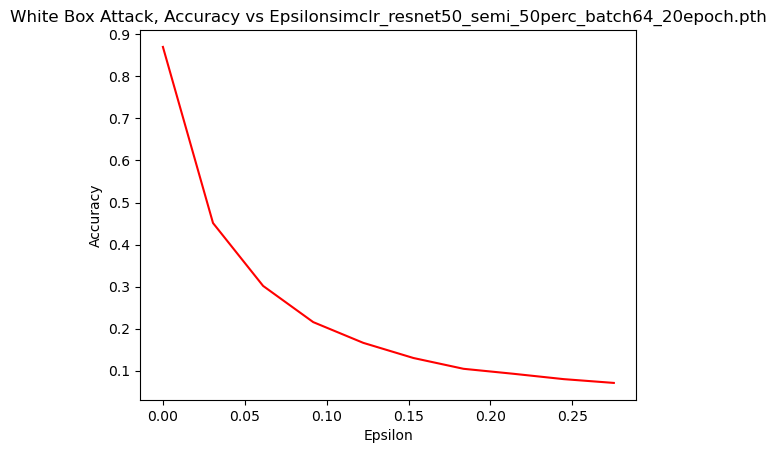

In [10]:
PATH = "simclr_resnet50_semi_50perc_batch64_20epoch.pth"
load_model="test_linear_eval"
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

net = process_model_type("simclr_resnet50", load_model="test_linear_eval")
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("simclr_resnet50", load_model="test_linear_eval")
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)

for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "PGD", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

acc: 0.8471
done: 0.0
acc: 0.5777
done: 0.030596666666666668
acc: 0.3803
done: 0.061193333333333336
acc: 0.2499
done: 0.09179000000000001
acc: 0.1756
done: 0.12238666666666667
acc: 0.1292
done: 0.15298333333333333
acc: 0.1013
done: 0.18358000000000002
acc: 0.0812
done: 0.21417666666666668
acc: 0.0703
done: 0.24477333333333334
acc: 0.0605
done: 0.27537
[0.8471, 0.5777, 0.3803, 0.2499, 0.1756, 0.1292, 0.1013, 0.0812, 0.0703, 0.0605]


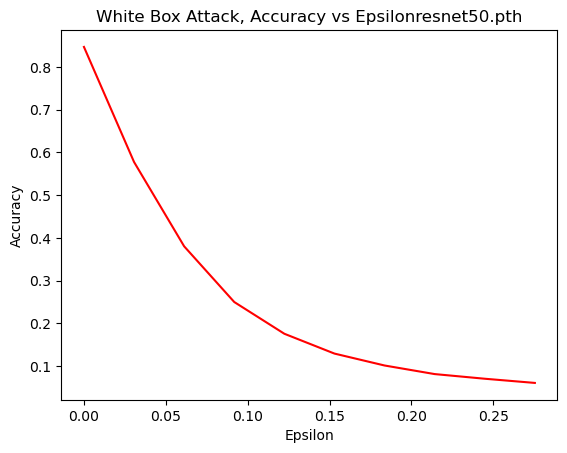

In [11]:
PATH = "resnet50.pth"
load_model="test_linear_eval"
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

net = process_model_type("resnet50", load_model=PATH)
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("resnet50", load_model=PATH)
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)

for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "PGD", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

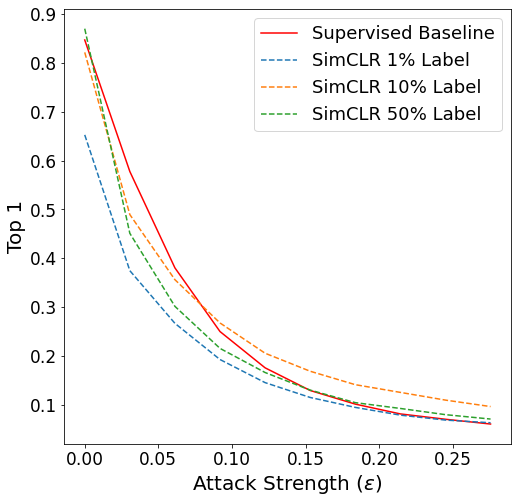

In [3]:
# resnet50_lineval_adv_acc = [0.7559, 0.3049, 0.1768, 0.114, 0.0798, 0.0604, 0.0469, 0.0379, 0.0327, 0.0281]
resnet50_1per_adv_acc = [0.6527, 0.3746, 0.2667, 0.1926, 0.1453, 0.1149, 0.0946, 0.0787, 0.0686, 0.0631]
resnet50_10per_adv_acc = [0.8217, 0.4895, 0.3561, 0.2675, 0.2055, 0.1686, 0.1411, 0.1253, 0.1095, 0.0963]
resnet50_50per_adv_acc = [0.8702, 0.4511, 0.3015, 0.2154, 0.166, 0.13, 0.1043, 0.0924, 0.0797, 0.0707]
resnet50_adv_acc = [0.8471, 0.5777, 0.3803, 0.2499, 0.1756, 0.1292, 0.1013, 0.0812, 0.0703, 0.0605]
eps_list = np.linspace(0, 0.1*2.7537, 10)

plt.figure(figsize=(8,8))
plt.plot(eps_list, resnet50_adv_acc, c='red')
plt.plot(eps_list, resnet50_1per_adv_acc, linestyle='dashed')
plt.plot(eps_list, resnet50_10per_adv_acc, linestyle='dashed')
plt.plot(eps_list, resnet50_50per_adv_acc, linestyle='dashed')
# plt.plot(eps_list, resnet50_lineval_adv_acc, linestyle='dashed')
# plt.title("White Box PGD Attack")
plt.xlabel("Attack Strength ($\\epsilon$)", fontsize=20)
plt.ylabel("Top 1", fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(["Supervised Baseline","SimCLR 1% Label", "SimCLR 10% Label", "SimCLR 50% Label", "SSL SimCLR"], fontsize=18)
plt.savefig('adv_pgd.png')
plt.show()

In [4]:
def test_whitebox(PATH, model_type, load_model, attack_type):
    whitebox_accs = []
    eps_list = np.linspace(0, 0.1*2.7537, 10)
    
    net = process_model_type("simclr_resnet50", load_model=load_model)
    net.load_state_dict(torch.load(PATH)['state_dict'])
    net.evaluate = True
    net.to(device)
    whitebox = process_model_type("simclr_resnet50", load_model=load_model)
    whitebox.load_state_dict(torch.load(PATH)['state_dict'])
    whitebox.evaluate = True
    whitebox.to(device)
    
    for eps in eps_list:
        whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, attack_type, device)
        whitebox_accs.append(whitebox_acc)
        print("acc:",whitebox_acc)
        print("done:",eps)
    print(whitebox_accs)
    plt.plot(eps_list, whitebox_accs, c='red')
    plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    return whitebox_accs

acc: 0.6527
done: 0.0
acc: 0.4329
done: 0.030596666666666668
acc: 0.3706
done: 0.061193333333333336
acc: 0.335
done: 0.09179000000000001
acc: 0.3061
done: 0.12238666666666667
acc: 0.283
done: 0.15298333333333333
acc: 0.2623
done: 0.18358000000000002
acc: 0.251
done: 0.21417666666666668
acc: 0.2327
done: 0.24477333333333334
acc: 0.2146
done: 0.27537
[0.6527, 0.4329, 0.3706, 0.335, 0.3061, 0.283, 0.2623, 0.251, 0.2327, 0.2146]


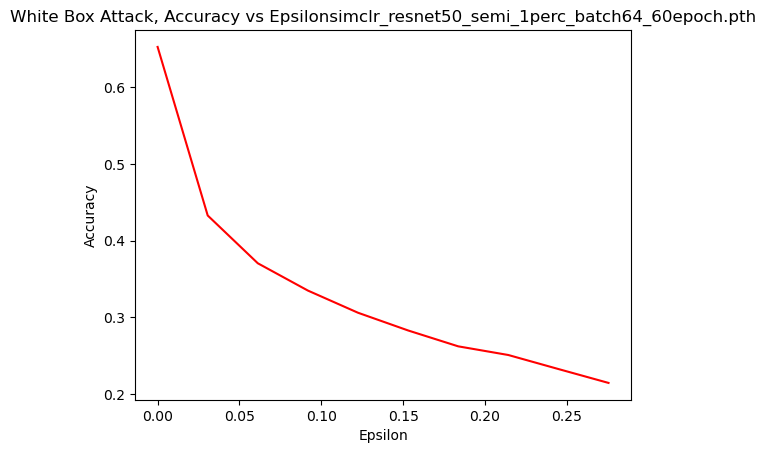

[0.6527, 0.4329, 0.3706, 0.335, 0.3061, 0.283, 0.2623, 0.251, 0.2327, 0.2146]

In [11]:
test_whitebox(PATH="simclr_resnet50_semi_1perc_batch64_60epoch.pth",
                  model_type="simclr_resnet50",
                  load_model="test_linear_eval",
                  attack_type="FGSM")

acc: 0.8217
done: 0.0
acc: 0.5686
done: 0.030596666666666668
acc: 0.4932
done: 0.061193333333333336
acc: 0.4469
done: 0.09179000000000001
acc: 0.412
done: 0.12238666666666667
acc: 0.3877
done: 0.15298333333333333
acc: 0.3661
done: 0.18358000000000002
acc: 0.3445
done: 0.21417666666666668
acc: 0.3205
done: 0.24477333333333334
acc: 0.2949
done: 0.27537
[0.8217, 0.5686, 0.4932, 0.4469, 0.412, 0.3877, 0.3661, 0.3445, 0.3205, 0.2949]


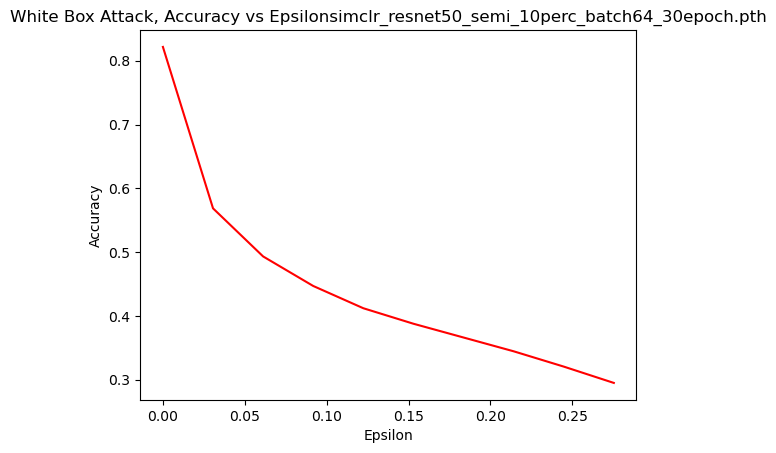

[0.8217, 0.5686, 0.4932, 0.4469, 0.412, 0.3877, 0.3661, 0.3445, 0.3205, 0.2949]

In [12]:
test_whitebox(PATH="simclr_resnet50_semi_10perc_batch64_30epoch.pth",
                  model_type="simclr_resnet50",
                  load_model="test_linear_eval",
                  attack_type="FGSM")

acc: 0.8702
done: 0.0
acc: 0.5543
done: 0.030596666666666668
acc: 0.4614
done: 0.061193333333333336
acc: 0.4117
done: 0.09179000000000001
acc: 0.3766
done: 0.12238666666666667
acc: 0.3528
done: 0.15298333333333333
acc: 0.3302
done: 0.18358000000000002
acc: 0.3024
done: 0.21417666666666668
acc: 0.2775
done: 0.24477333333333334
acc: 0.2555
done: 0.27537
[0.8702, 0.5543, 0.4614, 0.4117, 0.3766, 0.3528, 0.3302, 0.3024, 0.2775, 0.2555]


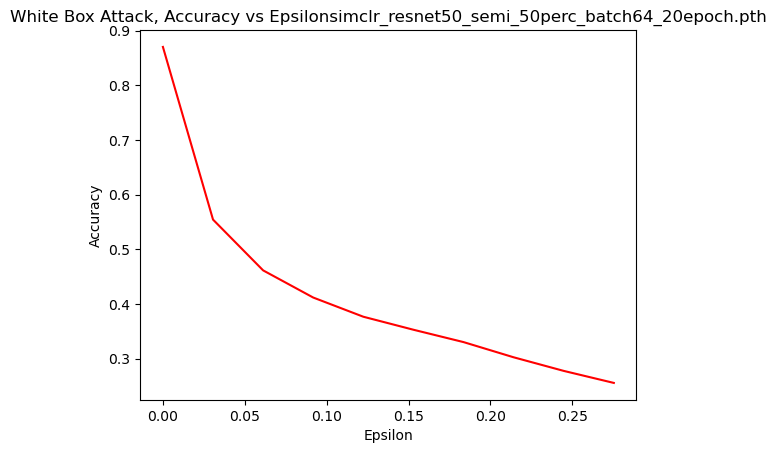

[0.8702,
 0.5543,
 0.4614,
 0.4117,
 0.3766,
 0.3528,
 0.3302,
 0.3024,
 0.2775,
 0.2555]

In [13]:
test_whitebox(PATH="simclr_resnet50_semi_50perc_batch64_20epoch.pth",
                  model_type="simclr_resnet50",
                  load_model="test_linear_eval",
                  attack_type="FGSM")

acc: 0.8471
done: 0.0
acc: 0.6666
done: 0.030596666666666668
acc: 0.5632
done: 0.061193333333333336
acc: 0.4964
done: 0.09179000000000001
acc: 0.438
done: 0.12238666666666667
acc: 0.3859
done: 0.15298333333333333
acc: 0.343
done: 0.18358000000000002
acc: 0.309
done: 0.21417666666666668
acc: 0.278
done: 0.24477333333333334
acc: 0.2556
done: 0.27537
[0.8471, 0.6666, 0.5632, 0.4964, 0.438, 0.3859, 0.343, 0.309, 0.278, 0.2556]


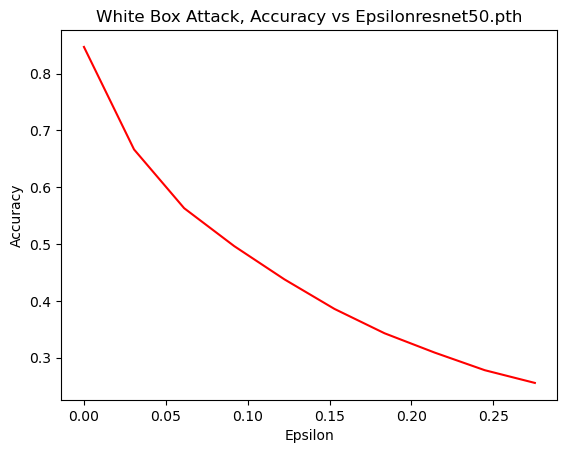

In [16]:
PATH = "resnet50.pth"
load_model="test_linear_eval"
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

net = process_model_type("resnet50", load_model=PATH)
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("resnet50", load_model=PATH)
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)

for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "FGSM", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

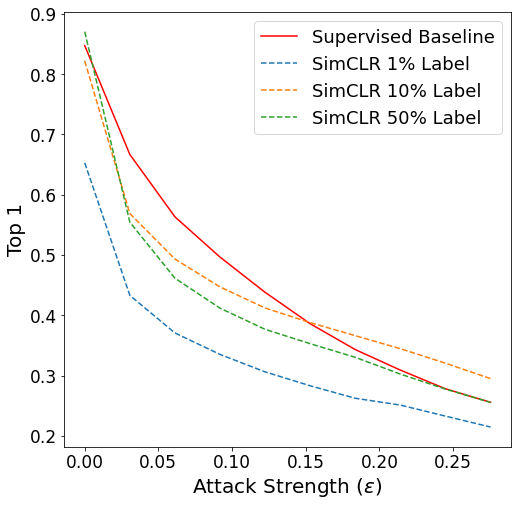

In [2]:
# resnet50_lineval_adv_acc = [0.7559, 0.4038, 0.3184, 0.2873, 0.2733, 0.2575, 0.2439, 0.2284, 0.2138, 0.1952]
resnet50_1per_adv_acc = [0.6527, 0.4329, 0.3706, 0.335, 0.3061, 0.283, 0.2623, 0.251, 0.2327, 0.2146]
resnet50_10per_adv_acc = [0.8217, 0.5686, 0.4932, 0.4469, 0.412, 0.3877, 0.3661, 0.3445, 0.3205, 0.2949]
resnet50_50per_adv_acc = [0.8702, 0.5543, 0.4614, 0.4117, 0.3766, 0.3528, 0.3302, 0.3024, 0.2775, 0.2555]
resnet50_adv_acc = [0.8471, 0.6666, 0.5632, 0.4964, 0.438, 0.3859, 0.343, 0.309, 0.278, 0.2556]
eps_list = np.linspace(0, 0.1*2.7537, 10)

plt.figure(figsize=(8,8))
plt.plot(eps_list, resnet50_adv_acc, c='red')
plt.plot(eps_list, resnet50_1per_adv_acc, linestyle='dashed')
plt.plot(eps_list, resnet50_10per_adv_acc, linestyle='dashed')
plt.plot(eps_list, resnet50_50per_adv_acc, linestyle='dashed')
# plt.plot(eps_list, resnet50_lineval_adv_acc, linestyle='dashed')
# plt.title("White Box PGD Attack")
plt.xlabel("Attack Strength ($\\epsilon$)", fontsize=20)
plt.ylabel("Top 1", fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(["Supervised Baseline","SimCLR 1% Label", "SimCLR 10% Label", "SimCLR 50% Label", "SSL SimCLR"], fontsize=18)
plt.savefig('adv_fgsm.png')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload

acc: 0.7559
done: 0.0
acc: 0.3049
done: 0.030596666666666668
acc: 0.1768
done: 0.061193333333333336
acc: 0.114
done: 0.09179000000000001
acc: 0.0798
done: 0.12238666666666667
acc: 0.0604
done: 0.15298333333333333
acc: 0.0469
done: 0.18358000000000002
acc: 0.0379
done: 0.21417666666666668
acc: 0.0327
done: 0.24477333333333334
acc: 0.0281
done: 0.27537
[0.7559, 0.3049, 0.1768, 0.114, 0.0798, 0.0604, 0.0469, 0.0379, 0.0327, 0.0281]


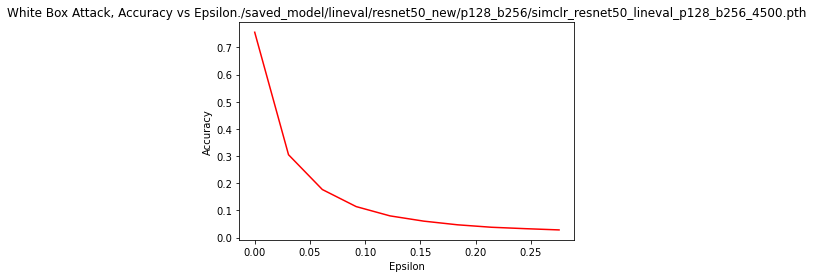

In [8]:
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

PATH = "./saved_model/lineval/resnet50_new/p128_b256/simclr_resnet50_lineval_p128_b256_4500.pth"

net = process_model_type("simclr_resnet50", load_model=PATH, load_entire=True)
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("simclr_resnet50", load_model=PATH, load_entire=True)
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)

for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "PGD", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

acc: 0.7559
done: 0.0
acc: 0.4038
done: 0.030596666666666668
acc: 0.3184
done: 0.061193333333333336
acc: 0.2873
done: 0.09179000000000001
acc: 0.2733
done: 0.12238666666666667
acc: 0.2575
done: 0.15298333333333333
acc: 0.2439
done: 0.18358000000000002
acc: 0.2284
done: 0.21417666666666668
acc: 0.2138
done: 0.24477333333333334
acc: 0.1952
done: 0.27537
[0.7559, 0.4038, 0.3184, 0.2873, 0.2733, 0.2575, 0.2439, 0.2284, 0.2138, 0.1952]


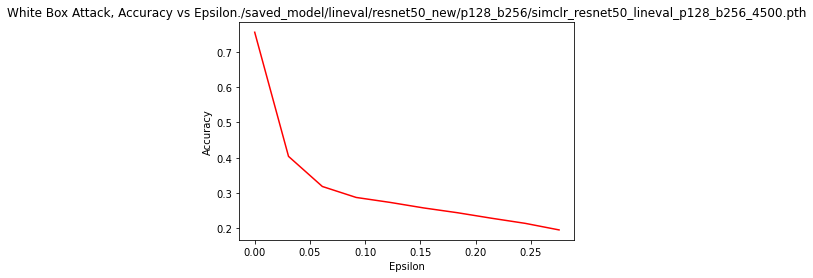

In [9]:
whitebox_accs = []
eps_list = np.linspace(0, 0.1*2.7537, 10)

PATH = "./saved_model/lineval/resnet50_new/p128_b256/simclr_resnet50_lineval_p128_b256_4500.pth"

net = process_model_type("simclr_resnet50", load_model=PATH, load_entire=True)
net.load_state_dict(torch.load(PATH)['state_dict'])
net.evaluate = True
net.to(device)
whitebox = process_model_type("simclr_resnet50", load_model=PATH, load_entire=True)
whitebox.load_state_dict(torch.load(PATH)['state_dict'])
whitebox.evaluate = True
whitebox.to(device)

for eps in eps_list:
    whitebox_acc = whitebox_attack_scaled_eps(net, whitebox, test_loader, eps, 10, "FGSM", device)
    whitebox_accs.append(whitebox_acc)
    print("acc:",whitebox_acc)
    print("done:",eps)
print(whitebox_accs)
plt.plot(eps_list, whitebox_accs, c='red')
plt.title("White Box Attack, Accuracy vs Epsilon" + PATH)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()